# Tutorial: Poisson regression with CatBoost
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/regression/poisson.ipynb)

# In this tutorial we are going to cover the following topics:

* The concept of count-based data
* What is Poisson regression and why it is suitable for count-based data
* How to build a Poisson regression model with CatBoost package
* How to predict the number of likes that the tweets of Elon Musk are going to get


## What is count based data?

By definition **count data** is a data type, in which:

1. The observations can take only the non-negative integer values {0, 1, 2, 3, ...}
2. These integers arise from *counting*

More specifically in our tutorial, we will focus on count-based data where each point is the number of events that have occurred over some fixed time unit $t$. We will also assume that on average during time unit $t$ number of events $\lambda$ occur. $\lambda$ is then called **event rate**. **Event rate can change over time or from one observation to another.** Here are some examples of such data:
* number of people visiting doctor each week
* number of vehicles crossing a bridge
* number of photos posted on Instagram each day
* number of "The Song of Fire Ice" books George R. R. Martin writes each two years

It is worth noticing that distribution of count-based data can be rather skewed with the majority of data points having exactly the same value. 

![image.png](https://sun9-26.userapi.com/c857428/v857428206/1b14d1/VVTqDwDktaA.jpg)

## Poisson regression

### Poisson distribution
Probability Mass Function of the Poisson distribution is the following:

$$P(k) = \frac{e^{-\lambda} (\lambda )^k}{k!}$$

Where $P(k)$ is probability of seeing k events during time unit given event rate (=number of events per time unit) $\lambda$. 

We can model count-based data with Poisson distribution.

Sample of Poisson distribution with constant $\lambda$ looks as follows: 







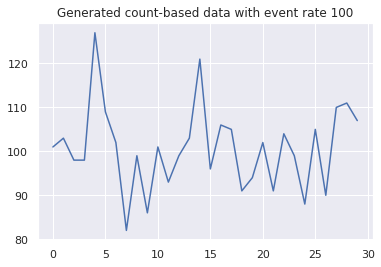

In [1]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
plt.plot(poisson(mu=100).rvs(size=30, random_state=0))
plt.title('Generated count-based data with event rate 100')
plt.show()

## Event rate $\lambda$ as dependent variable
The idea of Poisson regression is to say that event rate $\lambda$ is a dependent variable.

For instance the number of bicycles that cross a bridge per day depends on weather, time of the year, day of the week etc. We could build usual RMSE regression model, however such model would not account for the count-based properties of the data.  So in Poisson regression we would like to maximize log-likelihood for a Poisson distribution. Let $X$, $y$ be our dataset for Poisson regression task (meaning $y$ is count-based), then we want to maximize the log-likelihood:

$$\sum_{i=1}^{N} log(P_X(y)) = \sum_{i=1}^{N} log\left( \frac{e^{-\lambda(X_i) } (\lambda(X_i)) ^{y_i}}{y_i!} \right) = \sum_{i=1}^{N}\left( y_i \log (\lambda(X_i) ) - \lambda(X_i) - \log(y_i!) \right) $$

Since $\log(y_i !)$ does not depend on $X_i$ we drop this term and minimize the following loss:

$$L_{\text{poisson}} =  \sum_{i=1}^{N}\left(\lambda(X_i) - y_i \log (\lambda(X_i) )  \right)$$

This loss can be optimized with different models and optimization methods. In our tutorial we use CatBoost package.




## Training the Poisson regression model

In [1]:
!pip install catboost

     |████████████████████████████████| 64.4MB 61kB/s 


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error

# Dataset
Our dataset is collected with Twitter API. It consists of Elon Musk tweets. We are going to use tweets from March 2019 to January 2020 as a train set, the tweets from the first half of February 2020 as a validation set and the tweets from the second half of February 2020 as a test set. Our **target is number of likes** that tweets receive. In practice the majority of tweets receive all their likes during the first 2 weeks after publication, so we are going to assume that our time unit is two weeks. We collected the tweets that are at least two weeks old.

## Features

We extracted some quite simple features for our task:
* Tweet length 
* Number of other Twitter users mentions
* Number of urls in tweet
* Month
* Day
* Hour
* Day of week
* TF-IDF feature vector of size 500 (extracted with `sklearn.feature_extraction.text.TfidfVectorizer` with `stop_words="english"`)


In [6]:
!wget https://gist.githubusercontent.com/garkavem/06d05185e5b0685f2cd1cf37ac2a8568/raw/73e7ad0b508eab63be80a46262abc83ca77e898d/elon_tweets.csv

--2020-04-04 13:44:18--  https://gist.githubusercontent.com/garkavem/06d05185e5b0685f2cd1cf37ac2a8568/raw/73e7ad0b508eab63be80a46262abc83ca77e898d/elon_tweets.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.120.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.120.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6133224 (5,8M) [text/plain]
Saving to: ‘elon_tweets.csv’

elon_tweets.csv     100%[===================>]   5,85M  35,5MB/s    in 0,2s    

2020-04-04 13:44:18 (35,5 MB/s) - ‘elon_tweets.csv’ saved [6133224/6133224]



In [3]:
df = pd.read_csv('elon_tweets.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

id  n_mentions  n_urls  \
created_at                                                           
2019-03-16 20:05:14+00:00  1107009951266824192           2       0   
2019-03-16 20:10:50+00:00  1107011362423599104           3       0   
2019-03-16 20:38:07+00:00  1107018227727491073           3       0   
2019-03-16 20:45:24+00:00  1107020062177714176           2       0   
2019-03-16 20:53:52+00:00  1107022190426247168           3       0   

                           tweet_length  MONTH  DAY_OF_WEEK  DAY  HOUR  \
created_at                                                               
2019-03-16 20:05:14+00:00           191      3            5   16    20   
2019-03-16 20:10:50+00:00           214      3            5   16    20   
2019-03-16 20:38:07+00:00           312      3            5   16    20   
2019-03-16 20:45:24+00:00            68      3            5   16    20   
2019-03-16 20:53:52+00:00           153      3            5   16    20   

                           favorite_count  tfidf_000  ...  \
created_at                                            ...   
2019-03-16 20:05:14+00:00            7271        0.0  ...   
2019-03-16 20:10:50+00:00            1401        0.0  ...   
2019-03-16 20:38:07+00:00            1420        0.0  ...   
2019-03-16 20:45:24+00:00            4001        0.0  ...   
2019-03-16 20:53:52+00:00             742        0.0  ...   

                           tfidf_worldandscience  tfidf_worth  tfidf_wow  \
created_at                                                                 
2019-03-16 20:05:14+00:00                    0.0          0.0        0.0   
2019-03-16 20:10:50+00:00                    0.0          0.0        0.0   
2019-03-16 20:38:07+00:00                    0.0          0.0        0.0   
2019-03-16 20:45:24+00:00                    0.0          0.0        0.0   
2019-03-16 20:53:52+00:00                    0.0          0.0        0.0   

                           tfidf_wrong  tfidf_wsj  tfidf_yeah  tfidf_year  \
created_at                                                                  
2019-03-16 20:05:14+00:00          0.0        0.0         0.0         0.0   
2019-03-16 20:10:50+00:00          0.0        0.0         0.0         0.0   
2019-03-16 20:38:07+00:00          0.0        0.0         0.0         0.0   
2019-03-16 20:45:24+00:00          0.0        0.0         0.0         0.0   
2019-03-16 20:53:52+00:00          0.0        0.0         0.0         0.0   

                           tfidf_years  tfidf_yes  tfidf_zero  
created_at                                                     
2019-03-16 20:05:14+00:00          0.0        0.0         0.0  
2019-03-16 20:10:50+00:00          0.0        0.0         0.0  
2019-03-16 20:38:07+00:00          0.0        0.0         0.0  
2019-03-16 20:45:24+00:00          0.0        0.0         0.0  
2019-03-16 20:53:52+00:00          0.0        0.0         0.0  

[5 rows x 509 columns]

In [5]:
df_train = df[df.index < '2020-02-01']
df_val = df[(df.index >= '2020-02-01') & (df.index < '2020-02-15')]
df_test = df[(df.index >= '2020-02-15') & (df.index < '2020-03-01')]

In [6]:
train_pool = Pool(df_train.drop(['favorite_count', 'id'], 1),
                  label=df_train.favorite_count.values.astype(int)//100,
                  cat_features=['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR'])

val_pool = Pool(df_val.drop(['favorite_count', 'id'], 1),
                label=df_val.favorite_count.values.astype(int)//100,
                cat_features=['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR'])

test_pool = Pool(df_test.drop(['favorite_count', 'id'], 1),
                 label=df_test.favorite_count.values.astype(int)//100,
                 cat_features=['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR'])

Now we are going to train a CatBoost model with objective Poisson. We are going to choose the number of iterations using our validation dataset.

In [7]:
model = CatBoostRegressor(objective='Poisson')

model.fit(train_pool, plot=True, eval_set=val_pool, verbose=500)

actual_counts = df_test.favorite_count.values.astype(int) 
predicted_counts_poisson = model.predict(test_pool) * 100
r2_poisson = r2_score(actual_counts, predicted_counts_poisson)
rmse_score_poisson_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_poisson, rmse_score_poisson_model))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: -37.1328755	test: -35.4413116	best: -35.4413116 (0)	total: 63.1ms	remaining: 1m 3s
500:	learn: -1261.2416848	test: -1211.8665791	best: -1212.0040931 (396)	total: 3.14s	remaining: 3.13s
999:	learn: -1284.9729676	test: -1216.0634878	best: -1216.1679776 (972)	total: 5.63s	remaining: 0us

bestTest = -1216.167978
bestIteration = 972

Shrink model to first 973 iterations.
R2 score: 0.555
RMSE score: 39844.35


Coefficient of determination R2 value of 56% suggest that the predictions of our model on the test dataset explain more than a half of the target variability, which is not bad given the complexity of the task and the simplicity of our approach.

Also for comparison we are going to train a CatBoost model with standard RMSE objective: 

In [8]:
model = CatBoostRegressor(objective='RMSE')

model.fit(train_pool, plot=True, eval_set=val_pool, verbose=500)

predicted_counts_rmse = model.predict(test_pool) * 100
r2_rmse = r2_score(actual_counts, predicted_counts_rmse)
rmse_score_rmse_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_rmse))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_rmse, rmse_score_rmse_model))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055185
0:	learn: 599.2589244	test: 396.7177429	best: 396.7177429 (0)	total: 5.53ms	remaining: 5.53s
500:	learn: 335.7150964	test: 305.3383226	best: 295.2629075 (44)	total: 2.23s	remaining: 2.23s
999:	learn: 267.8801522	test: 333.0370452	best: 295.2629075 (44)	total: 4.52s	remaining: 0us

bestTest = 295.2629075
bestIteration = 44

Shrink model to first 45 iterations.
R2 score: 0.483
RMSE score: 42936.22


Seeing that the best iteration for RMSE model is 45 while for Poisson regression the best iteration is 972 we could suspect that the automatically chosen by CatBoost learning rate 0.055185 is too large for RMSE model. To tackle this possible unfairness we also train RMSE model with 30 times smaller learning rate:

In [9]:
model = CatBoostRegressor(objective='RMSE', learning_rate=0.002)

model.fit(train_pool, plot=True, eval_set=val_pool, verbose=500)

predicted_counts_rmse = model.predict(test_pool) * 100
r2_rmse = r2_score(actual_counts, predicted_counts_rmse)
rmse_score_rmse_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_rmse))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_rmse, rmse_score_rmse_model))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 610.3867820	test: 410.0202034	best: 410.0202034 (0)	total: 7.62ms	remaining: 7.62s
500:	learn: 491.2388246	test: 301.2801229	best: 301.2801229 (500)	total: 1.74s	remaining: 1.73s
999:	learn: 459.4417999	test: 300.0544408	best: 299.3609305 (748)	total: 3.25s	remaining: 0us

bestTest = 299.3609305
bestIteration = 748

Shrink model to first 749 iterations.
R2 score: 0.470
RMSE score: 43470.15


 Howevere smaller learning rate does not help RMSE model. 
 
 | | CatBoost-RMSE | CatBoost-Poisson 
--- | --- | ---
R2 score | 0.483 | 0.555 (+15%)
RMSE | 42936 | 39844.35 (-7%)
 
As can be seen the loss that accounts for the nature of the dataset yields better results than the standard RMSE loss. 

In [10]:
import plotly.express as px
import plotly.graph_objects as go

In [11]:
fig = go.Figure()
fig.update_layout(title={'text': "Elon Musk tweets likes prediction (test set)", 'x':0.4})

fig.add_trace(go.Bar(
    y=actual_counts[:],
    name='Actual likes',
    marker_color='green', opacity=0.5
))
fig.add_trace(go.Bar(
    y=predicted_counts_poisson[:],
    name='CatBoost-Poisson Predictions',
    marker_color='blue', opacity=0.3
))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(len(df_test))[1::5],
        ticktext = df_test.index.date[1::5]
    )
)
fig.update_layout(barmode='overlay', xaxis_tickangle=-45, yaxis_type="log")
fig.show()

**Thank you for your attention! I hope you find this tutorial useful.**